# <font color='#2F4F4F'>AfterWork Data Science: Text Classification with Python - Project</font>

## <font color='#2F4F4F'>Step 1. Business Understading </font>

### a) Specifying the Research Question

Build a text classification model that classifies a given text input as written in english or in dutch.

### b) Defining the Metric for Success

Build a classification model with an accuracy of score of atleast 85%.

### c) Understanding the Context 

You work as a Computational Linguist for a Global firm, collaborating with Engineers and
Researchers in Assistant and Research & Machine Intelligence to develop language
understanding models that improve our ability to understand and generate natural
language.

### d) Recording the Experimental Design

* Business Understanding
* Data Exploration
* Data Preparation
* Data Modeling and Evaluation
* Summary of Findings 
* Recommendation
* Challenges


## <font color='#2F4F4F'>Step 2. Data Importation</font>

In [1]:
# Importing the required libraries
# ---
# 
import pandas as pd # library for data manipulation
import numpy as np  # librariy for scientific computations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # scientific computing 
import seaborn as sns # library for data visualisation

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja 
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 

# Library for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

     |████████████████████████████████| 541 kB 5.0 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=814ba8afdcede011ed5fb8cb8ee1112e14424d662463bada9cc487b530894488
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Custom Functions
# ---
#

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0 
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity 
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [3]:
# loading and previewing the dataset
df = pd.read_csv('http://bit.ly/EnglishNDutchDs') 
df.sample(5)

,text,label
167,"United the The an and from of Union, and Federal neutrality; medieval is did against",en
806,In het centrum voor menselijke erfelijkheid in Leuven werken onder meer professoren JeanJacques Cassiman en,nl
626,zoon van de schrijnwerker Pierre Marcellis en van Marie Boon. Hij trouwde met Joséphine Regnier.,nl
55,down mayor Extended was opposition announced won support National the leader.[32] Conference.[35] he its,en
268,Orthochtha zuluensis is een rechtvleugelig insect uit de familie veldsprinkhanen (Acrididae). De wetenschappelijke naam van,nl


## <font color='#2F4F4F'>Step 3. Data Exploration</font>

In [4]:
# check dataset shape
df.shape

(1069, 2)

Our dataset has 1069 records and 2 variables.

In [5]:
# preview variable datatypes
df.dtypes

text     object
label    object
dtype: object

Both variables have the data type object. This is fine for the text variable, however for the label, we will need to convert it to a numerical format. We will do this later.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


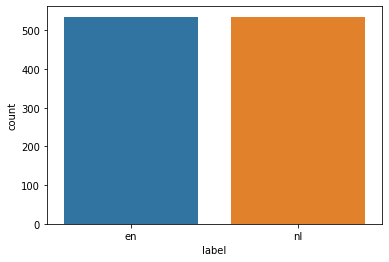

In [6]:
# plotting the distribution of label
# ---
#
sns.countplot(df['label']);

In [7]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

From above, we can see that our dataset is unbalanced thus we will need to sample equal no. of records for each label during data preparation to make a balanced dataset.

## <font color='#2F4F4F'>Step 4. Data Preparation</font>

### <font color='#2F4F4F'>3.1 Data Cleaning</font>

In [8]:
# check for duplicates
df.duplicated().sum()

10

There are 10 duplicates. We will need to drop these.

In [9]:
# check for missing values
df.isna().sum()

text     0
label    0
dtype: int64

No missing values found. 

In [10]:
# dropping our duplicates
df = df.drop_duplicates()
df.shape

(1059, 2)

In [11]:
# What values are in our label variable?
# ---
#
df.label.unique()

array(['en', 'nl'], dtype=object)

In [12]:
# sampling text with en 
df_en = df[df["label"] == 'en'] 
df_en = df_en.sample(200)

# sampling text with nl 
df_nl = df[df["label"] == 'nl'] 
df_nl = df_nl.sample(200)

# combining our dataframes
df = pd.concat([df_en, df_nl])
df.head()

,text,label
631,"Darlingia ferruginea grows as a tall tree in its native rainforest habitat, forming part of",en
124,"Corn of coffeehouse London and became London, mysteries. with the a British debate as especially",en
572,two elder sisters remained at Hohenburg where each served as abbess. At her own death,en
887,Dorygnathus was according to David Unwin related to the Late Jurassic pterosaur Rhamphorhynchus and was,en
952,The Cougars were coached for a st consecutive season by Jennifer Rockwood who was cocoach,en


In [13]:
# investigating the label distribution
df['label'].value_counts()

en    200
nl    200
Name: label, dtype: int64

We now have our balanced dataset. 

### <font color='#2F4F4F'> 3.2 Text Cleaning</font>

In [16]:
# We will create a custom function that will contain all the text cleaning 
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.
# ---
# 

def text_cleaning(tweet):
  # Removing url/links
  df['text'] = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+','', str(x)))

  # Removing @ and # characters and replacing them with space
  df['text'] = df.text.str.replace('#',' ')
  df['text'] = df.text.str.replace('@',' ') 

  # Conversion to lowercase 
  df['text'] = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing punctuation characters
  df['text'] = df.text.str.replace('[^\w\s]','')

  # Removing stop words
  df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # Lemmatization
  df['text'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [17]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 5-10 min.
# ---
#

df['text'].apply(text_cleaning)
df.sample(5)

,text,label
1061,andere chad uit cover de sittin een door stijl die stone ze eigentijdse,nl
505,tuples decision tree flowchartlike structure internal nonleaf node denotes,en
997,directly subject holy see roman congregation evangelization people,en
392,werd secretaris een vader broer medio met zijn tot derde afdeling hij negentig na r,nl
29,walfisch dia point king voyage coast cão south luís africa,en


### <font color='#2F4F4F'> 3.3 Feature Engineering</font>

In [21]:
# We will create a custom function that will contain all the 
# feature engineering techniques. We can then use this function 
# for cleaning new data. 
# ---
#
def feature_engineering(text):
  # Length of tweet
  df['length_of_tweet'] = df.text.str.len()

  # Word count 
  df['word_count'] = df.text.apply(lambda x: len(str(x).split(" ")))

  # Word density (Average no. of words / tweet)
  df['avg_word_length'] = df.text.apply(lambda x: avg_word(x)) 
  
  # Noun Count
  df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

  # Verb Count
  df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

  # Adjective Count / Tweet
  df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

  # Adverb Count / Tweet
  df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

  # Pronoun 
  df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

  # Subjectivity 
  df['subjectivity'] = df.text.apply(get_subjectivity)

  # Polarity
  df['polarity'] = df.text.apply(get_polarity)

In [22]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
df.text.apply(feature_engineering)
df.sample(5)

,text,label,length_of_tweet,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
197,carbon13 strongly originally specific case,en,42,5,7.600000,2,0,1,2,0,0.0,0.0
936,area together adjacent barrs boho upland,en,40,6,5.833333,4,0,1,1,0,0.0,0.0
454,de speler waar barcelona hij clãsico26 hattrick wedstrijden21 met seizoen hem kant competitietreffers van,nl,105,14,6.571429,9,2,1,0,0,0.0,0.0
631,darlingia ferruginea grows tall tree native rainforest habitat forming part,en,75,10,6.600000,5,2,3,0,0,0.0,0.0
1024,centering event around pawn shop pawn shop chronicle tell three,en,63,10,5.400000,6,2,0,0,0,0.0,0.0


In [24]:
# Performing further feature engineering techniques
# ---
#
# YOUR CODE GOES HERE

# Feature Construction: Word Level N-Gram TF-IDF Feature 
# ---
#
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text) 

# Feature Construction: Character Level N-Gram TF-IDF 
# ---
#
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)


In [25]:
df.head()

,text,label,length_of_tweet,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
631,darlingia ferruginea grows tall tree native rainforest habitat forming part,en,75,10,6.600000,5,2,3,0,0,0.0,0.0
124,corn coffeehouse london became london mystery british debate especially,en,71,9,7.000000,5,1,2,1,0,0.0,0.0
572,two elder sister remained hohenburg served abbess death,en,55,8,6.000000,2,3,2,0,0,0.0,0.0
887,dorygnathus according david unwin related late jurassic pterosaur rhamphorhynchus,en,81,9,8.111111,3,2,2,2,0,0.0,0.0
952,cougar coached st consecutive season jennifer rockwood cocoach,en,62,8,6.875000,5,1,2,0,0,0.0,0.0


In [26]:
# Let's prepare the constructed features for modeling
# ---
# We will select all variables but the target (which is the label) and text variables 
# ---
#  
X_metadata = np.array(df.iloc[:, 2:12])
X_metadata

array([[ 75.        ,  10.        ,   6.6       , ...,   0.        ,
          0.        ,   0.        ],
       [ 71.        ,   9.        ,   7.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 55.        ,   8.        ,   6.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 63.        ,  13.        ,   3.92307692, ...,   0.        ,
          0.        ,   0.        ],
       [ 81.        ,  13.        ,   5.30769231, ...,   0.        ,
          0.        ,   0.        ],
       [110.        ,  15.        ,   6.4       , ...,   0.        ,
          0.        ,   0.        ]])

In [27]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---
#
X = scipy.sparse.hstack([df_word_vect, df_char_vect,  X_metadata])
X

<400x2010 sparse matrix of type '<class 'numpy.float64'>'
	with 52628 stored elements in COOrdinate format>

In [32]:
df['label'].unique()

array(['en', 'nl'], dtype=object)

In [33]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---  
y = np.array(df['label'].replace(['en', 'nl'], ['0','1']))
y

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

##  <font color='#2F4F4F'>Step 5. Data Modeling</font>

We will carry out 10 types of classification analysis, namely:
1.  Logistic Regression
3.  Decision Trees Classification
4.  Support Vector Machine (SVM) Classification
5. K-Nearest Neighbors (KNN) Classification
6.  Gaussian Naive Bayes (NB) Classification
7.  BaggingClassifier
8.  RandomForestClassifier
9.  AdaBoostClassifier
10. GradientBoostingClassifier

We use their default parameters then compare the different classification models to assess the best performing one(s). 

In [34]:
# splitting into 80-20 train-test sets
# ---
#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Fitting our model
# ---
#

# Importing the algorithms
# ---
# 
from sklearn.linear_model import LogisticRegression      # Logistic Regression Classifier
from sklearn.tree import DecisionTreeClassifier          # Decision Tree Classifier
from sklearn.svm import SVC                              # SVM Classifier
from sklearn.naive_bayes import MultinomialNB            # Naive Bayes Classifier
from sklearn.neighbors import KNeighborsClassifier       # KNN Classifier

# Ensemble classifiers
from sklearn.ensemble import BaggingClassifier           # Bagging Meta-Estimator Classifier
from sklearn.ensemble import RandomForestClassifier      # RandomForest Classifier 
from sklearn.ensemble import AdaBoostClassifier          # AdaBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier  # AdaBoost GradientBoostingClassifier



# Instantiating our models
# ---
#
logistic_classifier = LogisticRegression(solver='saga', max_iter=800, multi_class='multinomial') # solver works well with a large dataset like ours
decision_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
naive_classifier = MultinomialNB() 

bagging_meta_classifier = BaggingClassifier()
random_forest_classifier = RandomForestClassifier()
ada_boost_classifier = AdaBoostClassifier(random_state=42)
gbm_classifier = GradientBoostingClassifier(random_state=42) 


# Training our models
# ---
#  
logistic_classifier.fit(X_train, y_train)
decision_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
naive_classifier.fit(X_train, y_train) 

bagging_meta_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
ada_boost_classifier.fit(X_train, y_train)
gbm_classifier.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


GradientBoostingClassifier(random_state=42)

In [37]:
# Making predictions
# ---
#
logistic_y_prediction = logistic_classifier.predict(X_test) 
decision_y_prediction = decision_classifier.predict(X_test) 
svm_y_prediction = svm_classifier.predict(X_test) 
knn_y_prediction = knn_classifier.predict(X_test) 
naive_y_prediction = naive_classifier.predict(X_test)  

bagging_y_classifier = bagging_meta_classifier.predict(X_test) 
random_forest_y_classifier = random_forest_classifier.predict(X_test) 
ada_boost_y_classifier = ada_boost_classifier.predict(X_test)
gbm_y_classifier = gbm_classifier.predict(X_test)


In [39]:
# Evaluating the Models
# ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Accuracy scores
#
print("Logistic Regression Classifier", accuracy_score(logistic_y_prediction, y_test))
print("Decision Trees Classifier", accuracy_score(decision_y_prediction, y_test))
print("SVN Classifier", accuracy_score(svm_y_prediction, y_test))
print("KNN Classifier", accuracy_score(knn_y_prediction, y_test))
print("Naive Bayes Classifier", accuracy_score(naive_y_prediction, y_test))
 
print("Bagging Classifier", accuracy_score(bagging_y_classifier, y_test))
print("Random Forest Classifier", accuracy_score(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", accuracy_score(ada_boost_y_classifier, y_test))
print("GBM Classifier", accuracy_score(gbm_y_classifier, y_test))


Logistic Regression Classifier 0.9625
Decision Trees Classifier 0.95
SVN Classifier 0.9125
KNN Classifier 0.925
Naive Bayes Classifier 0.975
Bagging Classifier 0.975
Random Forest Classifier 0.9875
Ada Boost Classifier 1.0
GBM Classifier 0.9875


since this is a balanced dataset, we can conclude that based on accuracy score, Ada Boost Classifer predicted the most correctly

In [41]:
# Confusion matrices
# ---
# 
print('Logistic Regression Classifier:')
print(confusion_matrix(logistic_y_prediction, y_test))

print('Decision Trees Classifier:')
print(confusion_matrix(decision_y_prediction, y_test))

print('SVN Classifier:')
print(confusion_matrix(svm_y_prediction, y_test))

print('KNN Classifier:')
print(confusion_matrix(knn_y_prediction, y_test))

print('Naive Bayes Classifier:')
print(confusion_matrix(naive_y_prediction, y_test))
 
print('Bagging Classifier:')
print(confusion_matrix(bagging_y_classifier, y_test))

print('Random Forest Classifier:')
print(confusion_matrix(random_forest_y_classifier, y_test))

print('Ada Boost Classifier:')
print(confusion_matrix(ada_boost_y_classifier, y_test))

print('GBM Classifier:')
print(confusion_matrix(gbm_y_classifier, y_test))



Logistic Regression Classifier:
[[42  1]
 [ 2 35]]
Decision Trees Classifier:
[[44  4]
 [ 0 32]]
SVN Classifier:
[[38  1]
 [ 6 35]]
KNN Classifier:
[[40  2]
 [ 4 34]]
Naive Bayes Classifier:
[[42  0]
 [ 2 36]]
Bagging Classifier:
[[43  1]
 [ 1 35]]
Random Forest Classifier:
[[44  1]
 [ 0 35]]
Ada Boost Classifier:
[[44  0]
 [ 0 36]]
GBM Classifier:
[[44  1]
 [ 0 35]]


In [42]:
# Classification Reports
# ---
# 
print("Logistic Regression Classifier", classification_report(logistic_y_prediction, y_test))
print("Decision Trees Classifier", classification_report(decision_y_prediction, y_test))
print("SVM Classifier", classification_report(svm_y_prediction, y_test))
print("KNN Classifier", classification_report(knn_y_prediction, y_test))
print("Naive Bayes Classifier", classification_report(naive_y_prediction, y_test))
 
print("Bagging Classifier", classification_report(bagging_y_classifier, y_test))
print("Random Forest Classifier", classification_report(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", classification_report(ada_boost_y_classifier, y_test))
print("GBM Classifier", classification_report(gbm_y_classifier, y_test))


Logistic Regression Classifier               precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.97      0.95      0.96        37

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

Decision Trees Classifier               precision    recall  f1-score   support

           0       1.00      0.92      0.96        48
           1       0.89      1.00      0.94        32

    accuracy                           0.95        80
   macro avg       0.94      0.96      0.95        80
weighted avg       0.96      0.95      0.95        80

SVM Classifier               precision    recall  f1-score   support

           0       0.86      0.97      0.92        39
           1       0.97      0.85      0.91        41

    accuracy                           0.91        80
   macro avg       0.92      0.91      0.91        80
we

## <font color='#2F4F4F'>Step 6. Summary of Findings and Recommendation</font>

Our best performing model was ADA Boost hence can be used to classify whether an input is in English or Dutch. 

## <font color='#2F4F4F'>Step 7. Challenging our Solution</font>

### a) Did we have the right question?
Yes we did 

### b) Did we have the right data?
Yes

### c) What can be done to improve the solution? 
To improve our model, we can try perfoming other text processing techniques that would better prepare our data for fitting our model. We can also implement other machine learning models, perform hyperparameter tuning.